# Animation of S-wave reflection of core-mantle boundary (phase ScS) in Cartesian coordinates

## Import libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## IASP91 1D model for S-wave velocity in Earth

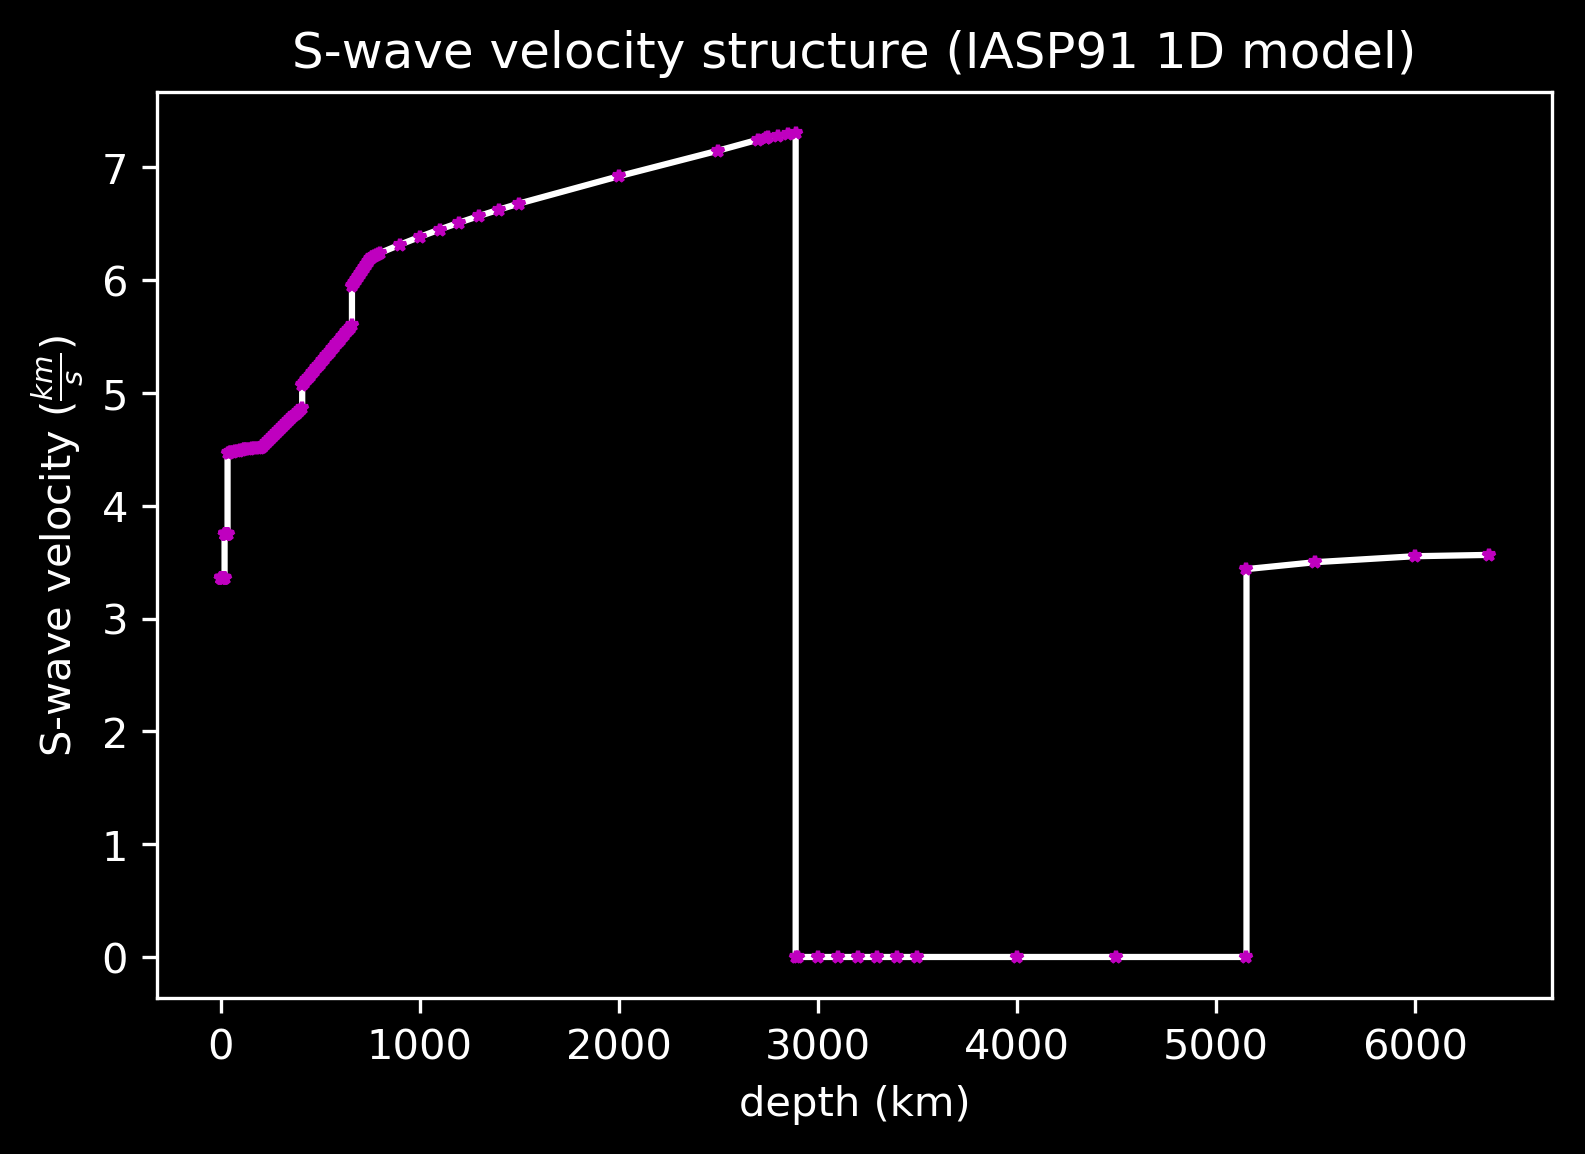

In [2]:
#download the file from http://ds.iris.edu/spud/earthmodel/9991809 in .csv format
#columns in the file correspond to depth (km), radius (km), Vp (km/s), and Vs (km/s)
#in this study I will be using depth of each layer and its Vs velocity

infile = open('IASP91.csv','r')
plt.style.use('dark_background')
s_vel = []
depth = []

for lines in infile:
    line = lines.split(',')
    s_vel.append(float(line[-1]))
    depth.append(float(line[0]))

#this plot shows that S-waves don't travel in the outer core
#I will be simulating how S-waves reflect off core-mantle boundary at 2889 km depth

plt.figure(dpi=300)
plt.plot(depth, s_vel, 'w')
plt.plot(depth, s_vel, 'm*', ms = 3)
plt.title('S-wave velocity structure (IASP91 1D model)')
plt.xlabel('depth (km)')
plt.ylabel(r'S-wave velocity ($\frac{km}{s}$)')
plt.savefig('iasp91.png')
plt.show()

infile.close()

Description of variables used to simulate wave reflection according to Snell's law ($\frac{sin\theta_{i}}{v_i}=const.$):
1. $u = \frac{1}{velocity}$ - slowness, changes in each layer.
2. $\theta$ - incident angle to the vertical. 10 rays will be generated with incident angles between 5$^{\circ}$ and 20$^{\circ}$.
3. $p = u\ \sin{\theta}$ - ray paremeter, it is preserved for a given ray and stays the same.

In [3]:
u0 = 1/s_vel[0] # initial slowness
theta0 = np.deg2rad(5) #minimum theta
theta1 = np.deg2rad(20) #maximum theta
k = 10 #number of rays generated

#generate empty lists for raypaths calculated later in the code

path_array_down = []  
path_array_up = []

#generate arrays of reversed velocity and depth structures for reflected raypaths

s_vel_up = []
depth_up = []
 
for i in reversed(s_vel):
    s_vel_up.append(i)

s_vel_up = s_vel_up[15:] #deleting the velocities that correspond to outer and inner core
    
for i in reversed(depth):
    depth_up.append(i)

depth_up = depth_up[15:] #deleting the depths that correspond to outer and inner core
    
    
for l in range(k):
    theta = theta0+(l-1)*(theta1-theta0)/k #generate initial angle for a given ray
    
    p = np.sin(theta)*u0 #initial ray parameter
    th = [np.sin(theta)] #stores the sinuses of incident angle for each layer 
    ds_l = [] #stores how long the path is between each layer
    dt_l = [] #stores time steps between each layer
    dx_l = [] #stores changes in x direction
    dy_l = [] #stores changes in y-direction

    sin_now = np.sin(theta) #initial sinus
    
    in_point = [0,depth[-1]] #point at which the seismic energy release happens (at surface)
    points = [in_point] #stores each point hit by given ray
    
    #loop over each layer to get where the raypath moves
    
    for i in range(1,np.argmin(s_vel)):
        
        u = 1./s_vel[i] #current layer slowness
        u_m = 1./s_vel[i-1] #previous layer slowness

        sin_now = u_m/u*th[i-1] #current layer sinus

        p = np.sin(np.arcsin(sin_now))*u #print out if you want to check that it is preserved
        dy = depth[i]-depth[i-1] #stores the change in y direction
        ds = dy*sin_now #raypath length between layers
        dt = dy*sin_now*u #time to travel between layers
        dx = ds/np.cos(np.arcsin(sin_now)) #change in x direction

        ds_l.append(ds)
        th.append(sin_now)
        dt_l.append(dt) 
        dx_l.append(dx)
        dy_l.append(dy)
    
    th1 = [th[-1]]
    ds_l1 = []
    dt_l1 = []
    dx_l1 = []
    dy_l1 = []
    u0 = 1/s_vel_up[0]
    p = np.sin(np.arcsin(th1[0]))*u0
    
    for i in range(1,len(s_vel_up)):      
        
        u = 1./s_vel_up[i] #current layer slownes
        u_m = 1./s_vel_up[i-1] #previous layer slowness

        sin_now = u_m/u*th1[i-1] #current layer sinus

        p = np.sin(np.arcsin(sin_now))*u #print out if you want to check that it is preserved
        
        dy = depth_up[i]-depth_up[i-1] #stores the change in y direction
        ds = dy*sin_now #raypath length between layers
        dt = dy*sin_now*u #time to travel between layers
        dx = ds/np.cos(np.arcsin(sin_now)) #change in x direction

        ds_l1.append(ds)
        th1.append(sin_now)
        dt_l1.append(dt)
        dx_l1.append(dx)
        dy_l1.append(dy)
    
    #appending points list with positions of the raypath
    for i in range(1,np.argmin(s_vel)):
        points.append([points[i-1][0]+dx_l[i-1],points[i-1][1]- dy_l[i-1]])
    
    #creating list for reflected positions
    in_point1 = points[-1]
    points1 = [in_point1]
    
    for i in range(1,np.argmin(s_vel)):    
        points1.append([points1[i-1][0]+dx_l1[-i+1],points1[i-1][1]+ dy_l1[-i+1]])
        
    fix = points1[0][0]+points1[-2][0]-points[-1][0] #for some reason the reflected array is a bit off so this is to fix that

    
    #Now I will be fitting a polynomial into the raypaths to have better distribution of points between layers
    #In IASP91 model the layers are not uniformly distributed and therefore layers have different width and some of them lack points to plot
    #I am then interpolating points between actual points to get a shape of a raypath
    #I have yet to figure out how to fix wavefronts that aren't in the correct shape
    #I hope to improve it by the presentation day
    
    x = []
    y = []
    
    x1 = []
    y1 = []
    
    
    for i in range(np.argmin(s_vel)):    
        x.append(points[i][0])
        y.append(points[i][1])
        x1.append(points1[0][0]+points1[i][0]-fix/2)
        y1.append(2889+points1[i][1])
        
        
    dx_list = np.array(x)
    dx_array = np.linspace(np.min(dx_list),np.max(dx_list),len(dx_list))
    dy_array = np.array(y)
    p = np.polyfit(dx_list, dy_array, 2)

    dx_list1 = np.array(x1)
    dx_array1 = np.linspace(np.min(dx_list1),np.max(dx_list1), len(dx_list1))
    dy_array1 = np.array(y1)
    p1 = np.polyfit(dx_list1, dy_array1, 2)

    #appending positions to path_array_{up,down} as [ray no., x-coord array, y-coord array]
    path_array_down.append([l, dx_array, p[0]*dx_array**2+p[1]*dx_array+p[2]])

    path_array_up.append([l, dx_array1, p1[0]*dx_array1**2+p1[1]*dx_array1+p1[2]])
        

In [4]:
#adding 'dummy' points at the begining and end of each array to fake a curved wavefront
#without this each ray was going at the same time and it didnt look scientifically correct
#at the end I join path_array_{down,up} to make it easier for display purposes

for i in range(k):

    a = np.zeros(int(((i+2)**2)/np.e))

    b = np.array([depth[-1] for i in range(int(((i+2)**2)/np.e))])

    path_array_down[i][1] = np.concatenate((a,path_array_down[i][1]))
    path_array_down[i][2] = np.concatenate((b,path_array_down[i][2]))
    
    
    path_array_down[i][1] =np.concatenate((path_array_down[i][1],path_array_up[i][1]))
    path_array_down[i][2] =np.concatenate((path_array_down[i][2],path_array_up[i][2]))
    
    xmax1 = np.max(path_array_down[i][1])
    
    c = np.array([xmax1 for i in range(int(((2*k-(i+2))**2)/np.e))])
    d = np.array([depth[-1] for i in range(int(((2*k-(i+2))**2)/np.e))])
    
    path_array_down[i][1] =np.concatenate((path_array_down[i][1],c))
    path_array_down[i][2] =np.concatenate((path_array_down[i][2],d))

    

## Animation of raypaths only:

0.........10.........20.........30.........40.........50.........60.........70.........80.........90.........100.........110.........120.........130.........140.........150.........160.........170.........180.........190.........200.........210.........220.........230.........240.........250.........260.........270.........280.........290.........300.........310.........320.........330.........340.........350.........360.........370.........380.........390... Simulation finished.


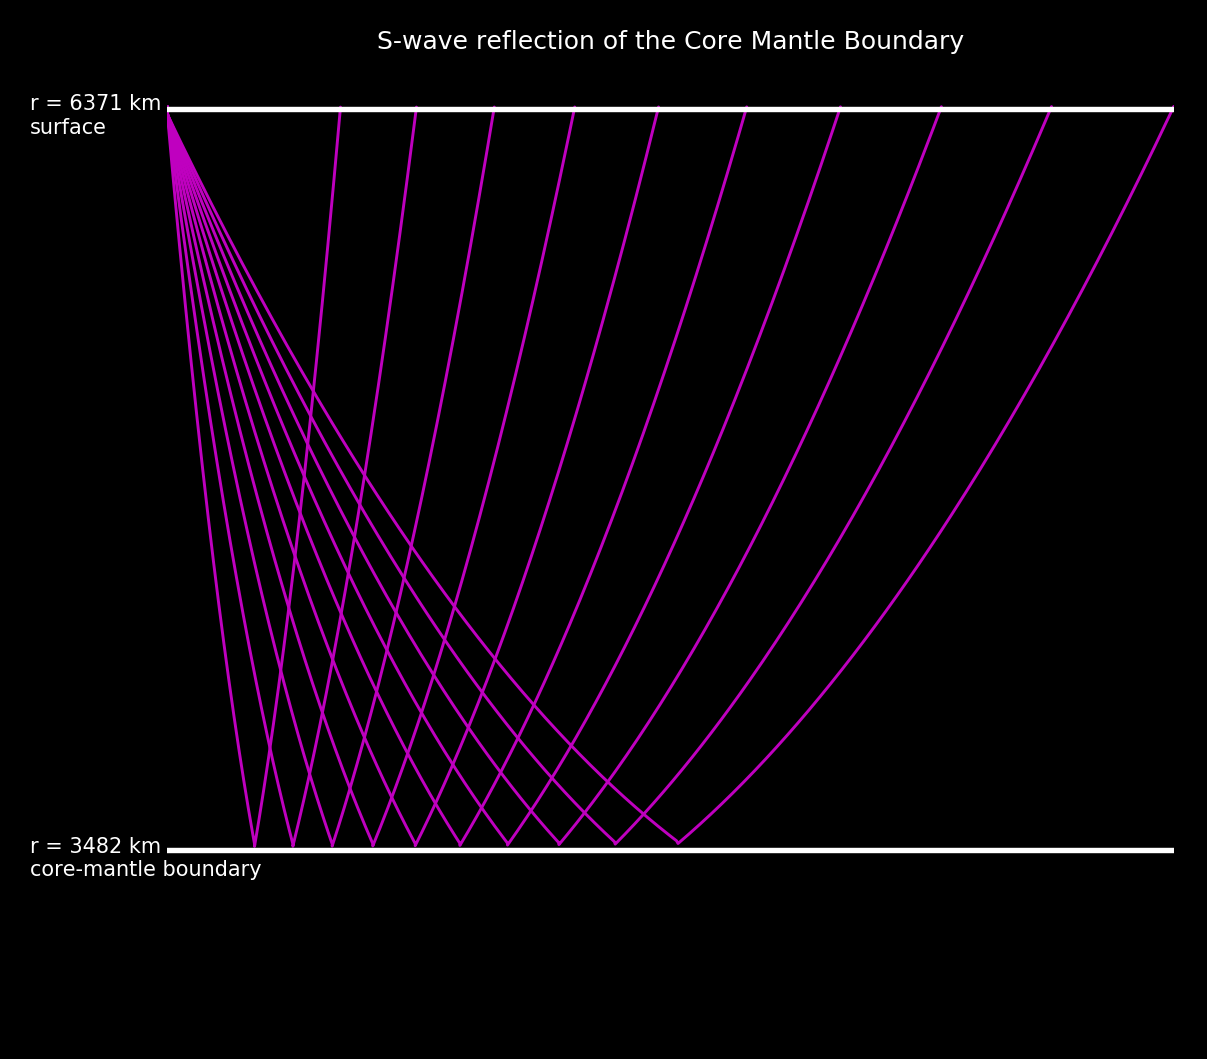

In [5]:
%matplotlib qt

from matplotlib.animation import FFMpegWriter
metadata = dict(title='ScS', artist='EK',comment='Nice.')
writer = FFMpegWriter(fps=15, metadata=metadata)

plt.rcParams['font.size'] = 5
plt.style.use('dark_background')
time = []
position = []

xmax = np.max(path_array_up[-1][1])
fig = plt.figure(dpi=300)

with writer.saving(fig, "animation2.mp4", dpi=300):
    for i in range(len(path_array_down[0][1])):

        plt.clf()
        
        for j in range(k):    
            plt.plot(path_array_down[j][1][0:i],  path_array_down[j][2][0:i], 'm', linewidth=0.7)
            
            for m in range(1,len(path_array_down[j][2])):
                if path_array_down[j][2][m] == 6371. and path_array_down[j][2][m-1] != 6371.:
                    time.append(m)
                    position.append(path_array_down[j][1][m])
        
        plt.annotate('r = 3482 km\ncore-mantle boundary', color = 'white', xy=(0, 3500), xytext=(-530, 3400))
        plt.annotate('r = 6371 km\nsurface', color = 'white', xy=(0, 6371), xytext=(-530, 6270))
        
        plt.axis('off')
        plt.xlim([0,xmax])
        plt.ylim([3000,6500])
        plt.plot(np.linspace(0,xmax,50),[20+depth[-1]-2889 for i in range(50)], color='w', label='CMB', linewidth=1.3)
        plt.plot(np.linspace(0,xmax,50), [depth[-1]-5 for i in range(50)], color = 'w', label='surface', linewidth=1.3)
        plt.title('S-wave reflection of the Core Mantle Boundary', color='w')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.draw()
        plt.pause(0.0001)
        writer.grab_frame()
        
        if i%10==0:
            print(i, end='')
            
        else:
            print('.',end='')

print(' Simulation finished.')

## Animation of station arrival only:

In [6]:
from matplotlib.animation import FFMpegWriter
metadata = dict(title='ScS arrival', artist='EK',comment='works fine')
writer = FFMpegWriter(fps=15, metadata=metadata)


time = np.zeros(len(path_array_down[0][2]))
position =  np.zeros(len(path_array_down[0][2]))

for j in range(k):
    for m in range(1,len(path_array_down[j][2])):
        if path_array_down[j][2][m] == 6371. and path_array_down[j][2][m-1] != 6371.:
            time[m] = m
            position[m] = path_array_down[j][1][m]
            
for i in range(len(time)):
        
    if time[i] == 0 and position[i] == 0:
        time[i]=float('NaN')
        position[i]=float('NaN')

%matplotlib qt

plt.rcParams['font.size'] = 5
plt.style.use('dark_background')
fig = plt.figure(dpi =300)

with writer.saving(fig, "animation3.mp4", dpi=300):
    plt.clf()
    for i in range(len(path_array_down[0][1])):
        plt.plot(position[0:i],time[0:i],'m*',ms=4)
        plt.title('Arrival at the station')
        plt.ylim([0,400])
        plt.xlim([0,4000])
        plt.xlabel('earthquake - station distance (km)')
        plt.ylabel('iteration')
        plt.draw()
        plt.pause(0.001)
        writer.grab_frame()
        
        if i%10==0:
            print(i, end='')
            
        else:
            print('.',end='')

print(' Simulation finished.')

0.........10.........20.........30.........40.........50.........60.........70.........80.........90.........100.........110.........120.........130.........140.........150.........160.........170.........180.........190.........200.........210.........220.........230.........240.........250.........260.........270.........280.........290.........300.........310.........320.........330.........340.........350.........360.........370.........380.........390... Simulation finished.


## Both plots combined into one animation:

In [7]:
%matplotlib qt

print('Simulation initiated.')

from matplotlib.animation import FFMpegWriter
metadata = dict(title='S-wave propagation', artist='EK',comment='Nice.')
writer = FFMpegWriter(fps=30, metadata=metadata)

time = np.zeros(len(path_array_down[0][2]))
position =  np.zeros(len(path_array_down[0][2]))

for j in range(k):
    for m in range(1,len(path_array_down[j][2])):
        if path_array_down[j][2][m] == 6371. and path_array_down[j][2][m-1] != 6371.:
            time[m] = m
            position[m] = path_array_down[j][1][m]
            
for i in range(len(time)):
        
    if time[i] == 0 and position[i] == 0:
        time[i]=float('NaN')
        position[i]=float('NaN')



plt.rcParams['font.size'] = 5
plt.style.use('dark_background')
xmax = np.max(path_array_up[-1][1])
fig = plt.figure(dpi=300)


with writer.saving(fig, "animation1.mp4", dpi=300):
    for i in range(len(path_array_down[0][1])):

        plt.clf()
        ax1 = fig.add_subplot(121,aspect='equal')
        for j in range(k):    
            ax1.plot(path_array_down[j][1][0:i],  path_array_down[j][2][0:i], 'm', linewidth=0.7)
            
        ax1.annotate('r = 3482 km\ncore-mantle boundary', color = 'w', xy=(0, 3500), xytext=(-530, 3200))
        ax1.annotate('r = 6371 km\nsurface', color = 'w', xy=(0, 6371), xytext=(-530, 6270))
        
        ax1.axis('off')
        ax1.set_xlim([0,xmax])
        ax1.set_ylim([3000,6500])
        ax1.plot(np.linspace(0,xmax,50),[20+depth[-1]-2889 for i in range(50)], color='w', label='CMB', linewidth=1.3)
        ax1.plot(np.linspace(0,xmax,50), [depth[-1]-5 for i in range(50)], color = 'w', label='surface', linewidth=1.3)
        ax1.set_title('S-wave reflection of the Core Mantle Boundary', color='w')
        
        ax2 = fig.add_subplot(122, aspect=8)
    
        ax2.plot(position[0:i], time[0:i], 'm*', ms=2)
        ax2.set_xlabel('earthquake - station distance (km)')
        ax2.set_ylabel("iteration")
        ax2.set_xlim([0,xmax+50])
        ax2.set_ylim([100,400])
        ax2.set_title('Arrival at the station')

        plt.tight_layout()
        plt.draw()
        plt.pause(0.0001)
        writer.grab_frame()
        
        if i%10==0:
            print(i, end='')
            
        else:
            print('.',end='')

print(' Simulation finished.')

Simulation initiated.
0.........10.........20.........30.........40.........50.........60.........70.........80.........90.........100.........110.........120.........130.........140.........150.........160.........170.........180.........190.........200.........210.........220.........230.........240.........250.........260.........270.........280.........290.........300.........310.........320.........330.........340.........350.........360.........370.........380.........390... Simulation finished.
